The catch rate or Catch per Unit of Effort (CPUE) is the catch per unit of effort over a time interval and defined:
$$
\begin{equation*}
CPUE = \frac{C}{F} = q . B
\end{equation*}$$

***C = Catch(Kg),  F = Effort over time (hours), B = Population Abundance, q = Catchability***

From the details given on the features and the equation above, to analyse population abundance I will undertake catch prediction using regression method based on gradient boosted decision trees.

In [1]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt  # Import pyplot for plotting
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns            # Seaborn, useful for graphics
%matplotlib inline 
# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
# This Function takes as input a custom palette
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

In [2]:
# loading fish dataset
data = pd.read_csv('fish_data2.csv')
data.shape

(47851, 10)

In [3]:
data.head(5)

,Year,Month,Day,Vessel_ID,catch_kg,Long,Lat,Depth,DayNight,Effort_hr
0,1991,2,17,1,80.0,144.50,41.58,NaN,D,4.0
1,1991,3,16,1,80.0,143.88,41.00,NaN,D,5.0
2,1991,4,9,1,40.0,144.38,41.61,500.0,M,4.5
3,1987,2,7,1,20.0,143.96,41.10,548.0,D,3.5
4,1987,3,12,1,30.0,144.06,41.20,457.0,D,3.0


In [4]:
## Checking feature types
def coltype(df):
        datatype1 = df.select_dtypes(include = ['float64', 'int64']).dtypes
        print('**** Number of numeric features = {} ****'.format(datatype1.count()))
        print(datatype1)
    
        datatype2 = df.select_dtypes(exclude = ['float64', 'int64']).dtypes
        print('\n**** Number of non-numeric features = {} ****'.format(datatype2.count()))
        print(datatype2)
        
coltype(data)

**** Number of numeric features = 9 ****
Year           int64
Month          int64
Day            int64
Vessel_ID      int64
catch_kg     float64
Long         float64
Lat          float64
Depth        float64
Effort_hr    float64
dtype: object

**** Number of non-numeric features = 1 ****
DayNight    object
dtype: object


In [5]:
print(data.shape), print("\n")
FeaCol = ['Year', 'Month', 'Day', 'DayNight', 'Vessel_ID']
for col in FeaCol:
    print('\nNumber of unique feature[{}] = {}'.format(col,  len(data[col].unique().tolist())))
    print(data[col].unique())

(47851, 10)



Number of unique feature[Year] = 30
[1991 1987 1988 1989 1990 1994 1986 1992 2011 2010 2007 2008 2009 2014 2012
 2015 1993 1995 1996 1997 1998 1999 2000 2002 2001 2003 2004 2006 2005 2013]

Number of unique feature[Month] = 12
[ 2  3  4  5  6  7  9 10 11 12  1  8]

Number of unique feature[Day] = 31
[17 16  9  7 12 21 22 23 25 26 18 15 24  3 30  1 11 13 14 28 29  8  4  5 19
  6 20  2 10 27 31]

Number of unique feature[DayNight] = 4
['D' 'M' 'N' 'U']

Number of unique feature[Vessel_ID] = 149
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 

In [6]:
#Gives the number of missing values in each column as isnull() 
data.apply(lambda x: sum(x.isnull()),axis=0) 

Year            0
Month           0
Day             0
Vessel_ID       0
catch_kg        0
Long            0
Lat             0
Depth         247
DayNight        0
Effort_hr    2738
dtype: int64

There are about **3,000 rows** missing. This doesn't seem a lot compare to the total flight of over **47,851 rows** just small percentage of the flights. Therefore, I can avoid to just remove them.

In [7]:
## Removes rows with missing values    
data = data[~pd.isnull(data).any(axis=1)]
data.shape

(44925, 10)

In [8]:
#Checking the number of missing values in each column again
data.apply(lambda x: sum(x.isnull()),axis=0) 

Year         0
Month        0
Day          0
Vessel_ID    0
catch_kg     0
Long         0
Lat          0
Depth        0
DayNight     0
Effort_hr    0
dtype: int64

In [9]:
## Compute the summary stats <=> describe(frame, 'price')
def describe(df, col):
    desc = df[col].describe()
    
    ## Change the name of the 50% index to median
    idx = desc.index.tolist()
    idx[5] = 'median'
    desc.index = idx
    return desc

describe(data,["catch_kg","Long","Lat","Depth","Effort_hr"])

,catch_kg,Long,Lat,Depth,Effort_hr
count,44925.000000,44925.000000,44925.000000,44925.000000,44925.000000
mean,136.271763,137.777057,37.227177,352.473434,4.139058
std,381.727944,5.379957,2.377972,131.942225,1.564436
min,0.500000,115.780000,32.216670,10.000000,-7.000000
25%,12.500000,137.400000,36.866670,274.000000,3.000000
median,37.500000,139.650000,37.716670,356.000000,4.000000
75%,100.000000,141.133330,38.566670,440.000000,5.080000
max,12849.600000,144.933330,41.999000,2194.000000,29.370000


From literature and intuition, temperature seems to play a role in fish catch per unit hour(which is proportional realationship with fish abundance). 
As such, I am interested to see visually how temperature affects the data using months and seasons.

In [10]:
# Add a column for seasons
data['Seasons'] = ['Spring[Sep-Nov]' if x in [9,10,11] else
                                 ('Summer[Dec-Feb]' if x in [12, 1,2] else 
                                 ('Autumn[Mar-May]' if x in [3,4,5] else
                                 'Winter[Jun-Aug]' )) for x in data['Month']] 

# Add a column for month name
data['MonthName'] = ['Jan' if x in [1] else
                                 ('Feb' if x in [2] else 
                                 ('Mar' if x in [3] else
                                 ('Apr' if x in [4] else
                                 ('May' if x in [5] else 
                                 ('Jun' if x in [6] else
                                 ('Jul' if x in [7] else
                                 ('Aug' if x in [8] else 
                                 ('Sep' if x in [9] else
                                 ('Oct' if x in [10] else
                                 ('Nov' if x in [11] else 
                                 'Dec' )))))))))) for x in data['Month']] 

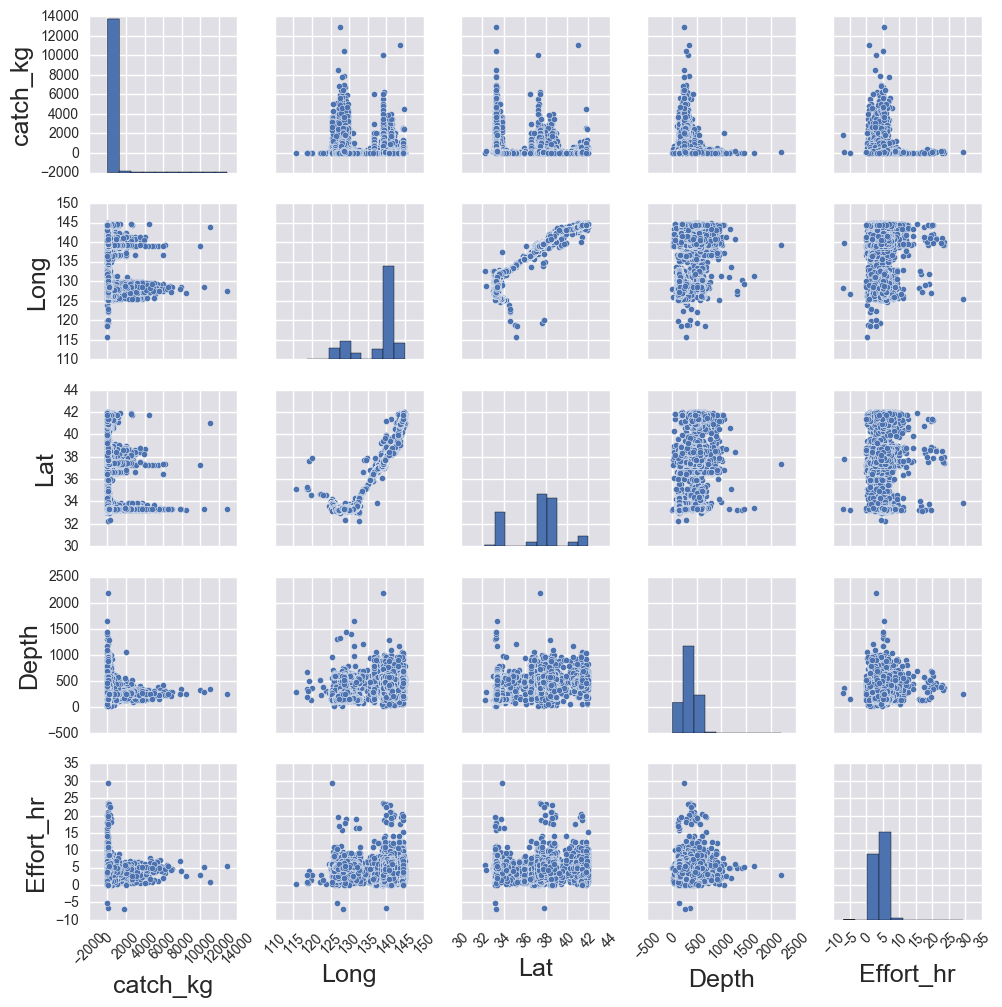

In [11]:
g = sns.pairplot(data.drop(['Year','Month','Day','Vessel_ID','Seasons','MonthName'],axis=1), size=2)
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45)

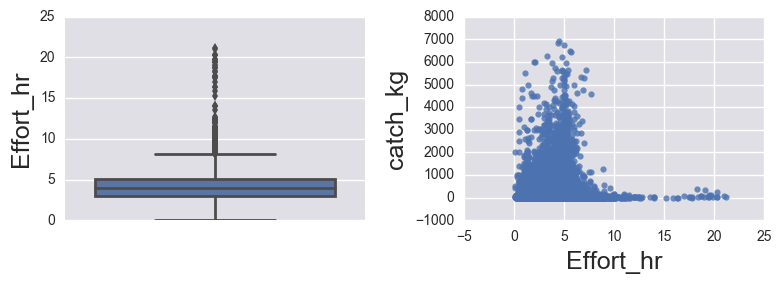

In [12]:
# negative or zero effort over a time and other outliers are excluded
data = data[data.Effort_hr>0]
data = data[data.Depth<1200]
data = data[data.Long>123]
data = data[data.Effort_hr<22]
data = data[data.catch_kg<7250]

# define plot function, and in this function, we will calculate the skew of X and take the log1p of y
def plot_outlier(x,y):    
    fig,axs=plt.subplots(1,2,figsize=(8,3))
    sns.boxplot(x,orient='v',ax=axs[0])
    sns.regplot(x,y,fit_reg=False,ax=axs[1])
    plt.tight_layout()
    
plot_outlier(data['Effort_hr'], data['catch_kg'])

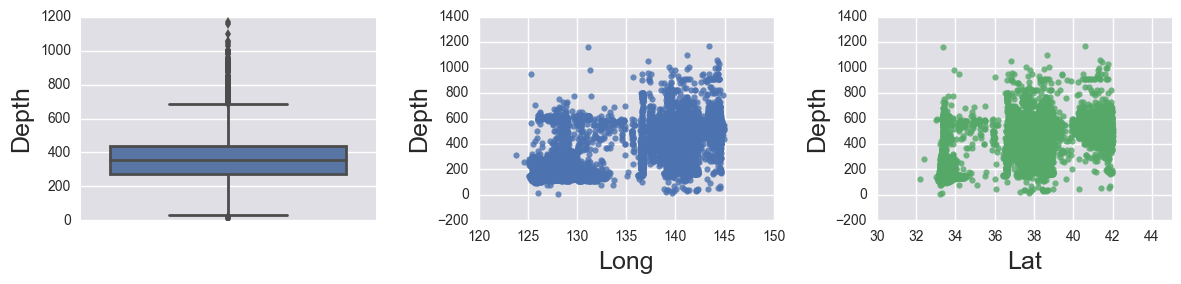

In [13]:
fig,axs=plt.subplots(1,3,figsize=(12,3))
sns.boxplot(data['Depth'],orient='v',ax=axs[0])
sns.regplot(data['Long'],data['Depth'],fit_reg=False,ax=axs[1])
sns.regplot(data['Lat'],data['Depth'],fit_reg=False,ax=axs[2])
plt.xlim(30, 45) 
plt.tight_layout()

In [14]:
print(data.shape)
FeaCol = ['Year', 'Month', 'Day', 'DayNight', 'Vessel_ID']
for col in FeaCol:
    print('\nNumber of unique feature[{}] = {}'.format(col,  len(data[col].unique().tolist())))
    print(data[col].unique())

(44875, 12)

Number of unique feature[Year] = 30
[1991 1987 1988 1989 1990 1994 1986 1992 2011 2010 2007 2008 2009 2014 2012
 2015 1993 1995 1996 1997 1998 1999 2000 2002 2001 2003 2004 2006 2005 2013]

Number of unique feature[Month] = 12
[ 4  2  3  5  6  7  9 10 11 12  1  8]

Number of unique feature[Day] = 31
[ 9  7 12 21 22 23 25 26 16 17 18 15 24  3 30  1 11 13 14 28 29  8  4  5 19
  6 20  2 10 27 31]

Number of unique feature[DayNight] = 4
['M' 'D' 'N' 'U']

Number of unique feature[Vessel_ID] = 123
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  48  49  50  51  52  53  54  55
  56  57  58  59  60  62  63  64  65  66  67  68  69  70  71  72  73  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 105 106 110 112 115 117 119 120
 122 127 128 129 131 135 136 137 138 140 142 143 14

In [15]:
## Compute the summary stats <=> describe(frame, 'price')
describe(data,["catch_kg","Long","Lat","Depth","Effort_hr"])

,catch_kg,Long,Lat,Depth,Effort_hr
count,44875.000000,44875.000000,44875.000000,44875.000000,44875.000000
mean,134.812280,137.784455,37.228902,352.290206,4.138981
std,361.736886,5.371522,2.377551,131.048358,1.542722
min,0.500000,123.830000,32.216670,10.000000,0.040000
25%,12.500000,137.400000,36.880000,274.000000,3.000000
median,37.500000,139.650000,37.716670,356.000000,4.000000
75%,100.000000,141.133330,38.566670,440.000000,5.080000
max,6912.000000,144.933330,41.999000,1170.000000,21.160000


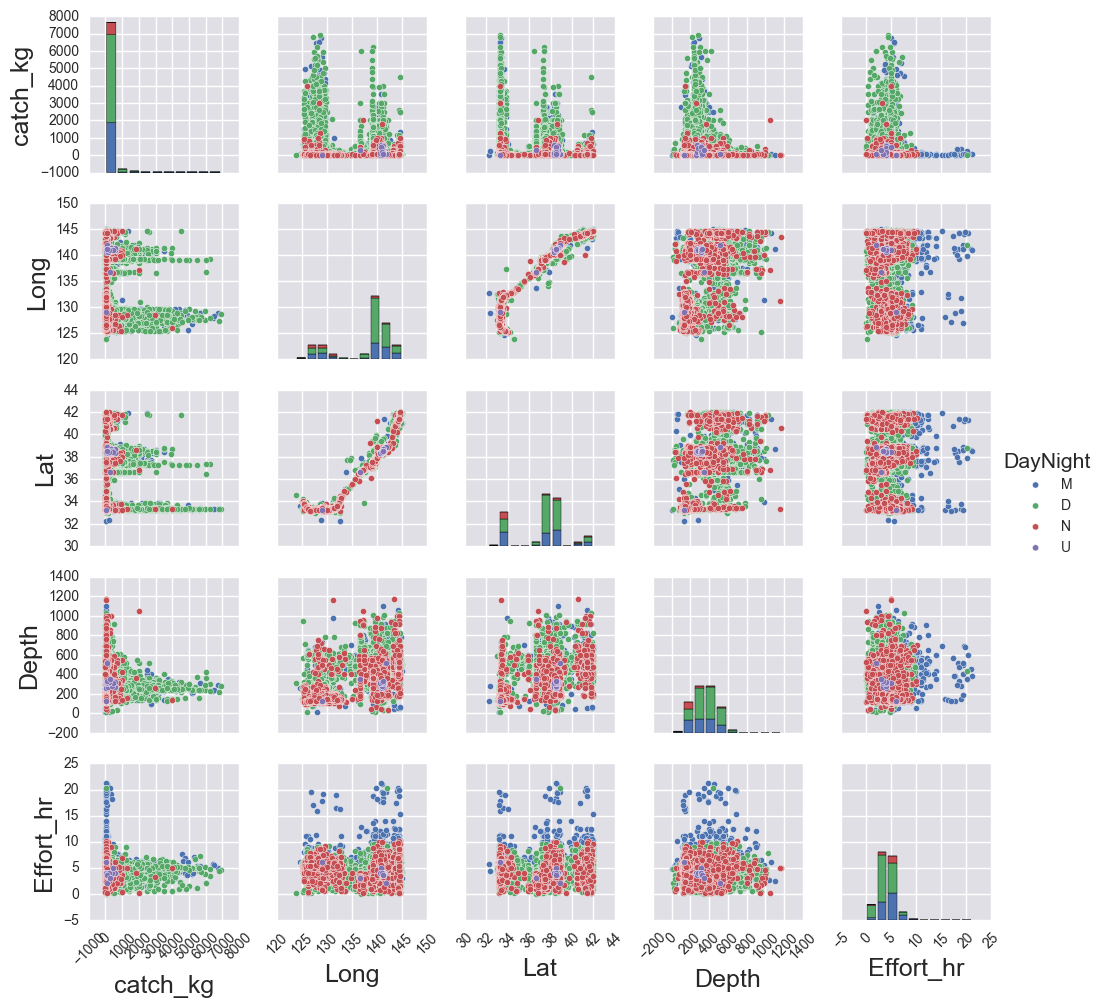

In [16]:
g = sns.pairplot(data.drop(['Year','Month','Day','Vessel_ID','Seasons','MonthName'],axis=1), hue='DayNight', size=2)
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45)

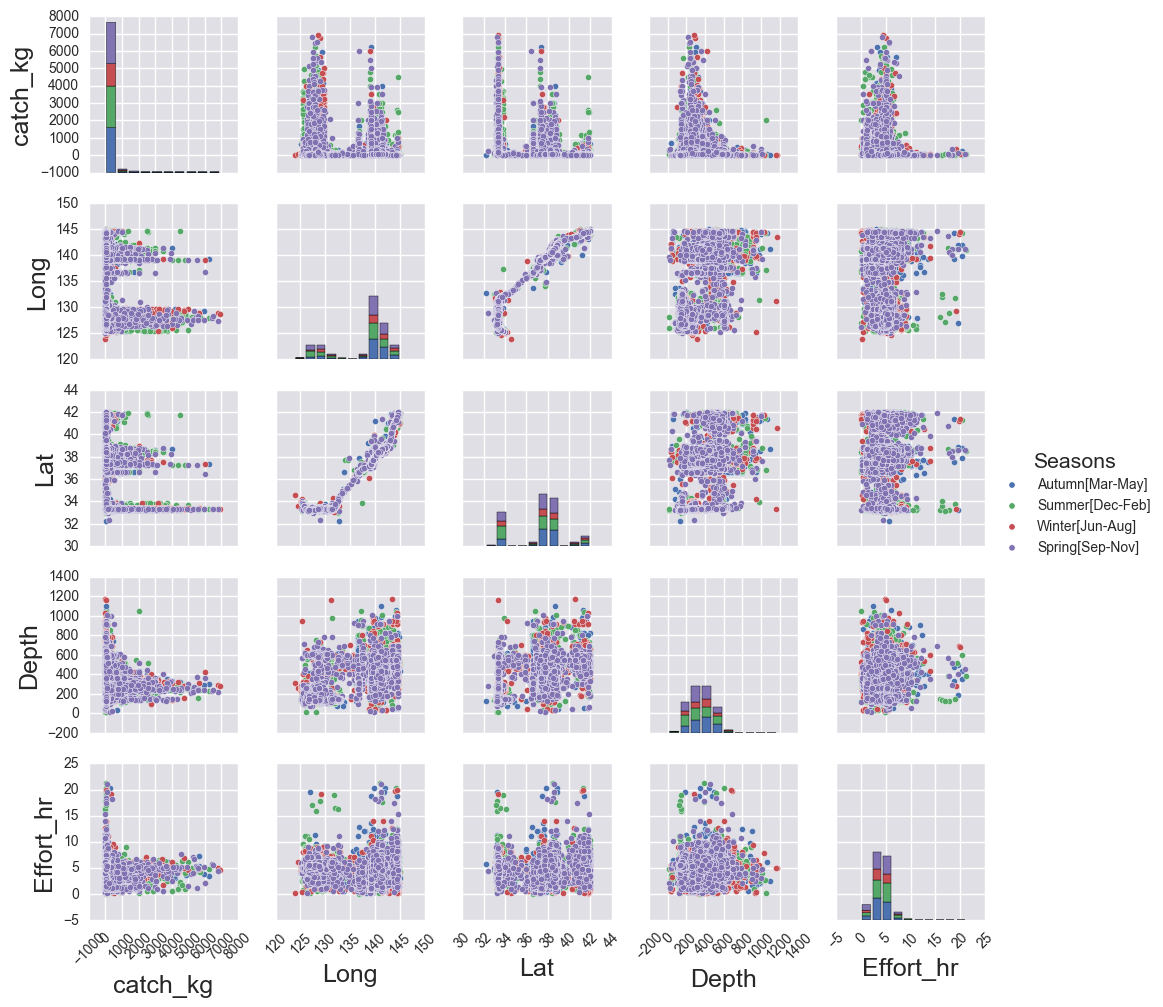

In [17]:
g = sns.pairplot(data.drop(['Year','Month','Day','Vessel_ID','DayNight','MonthName'],axis=1), hue="Seasons", size=2)
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45)

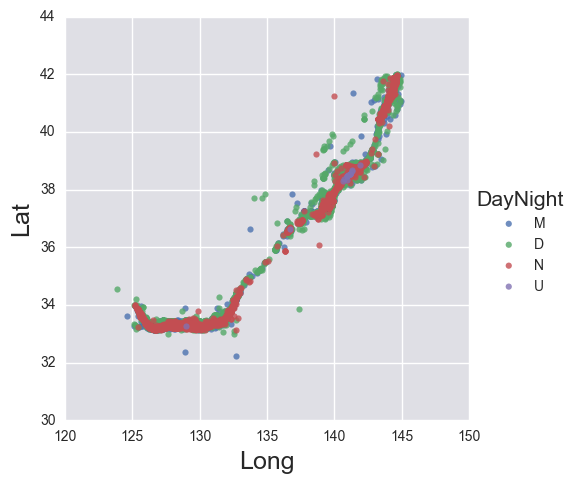

In [18]:
sns.lmplot('Long', 'Lat', data=data, fit_reg=False,hue='DayNight')

In [19]:
data['DayNight'].unique()

array(['M', 'D', 'N', 'U'], dtype=object)

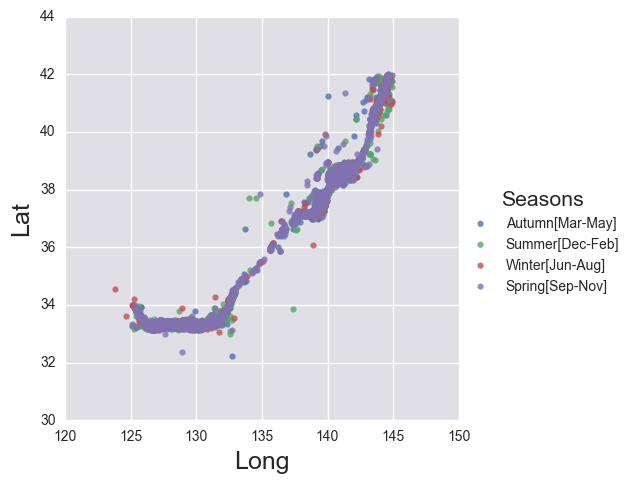

In [20]:
sns.lmplot('Long', 'Lat', data=data, fit_reg=False,hue='Seasons')

In [21]:
data['Seasons'].unique()

array(['Autumn[Mar-May]', 'Summer[Dec-Feb]', 'Winter[Jun-Aug]',
       'Spring[Sep-Nov]'], dtype=object)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

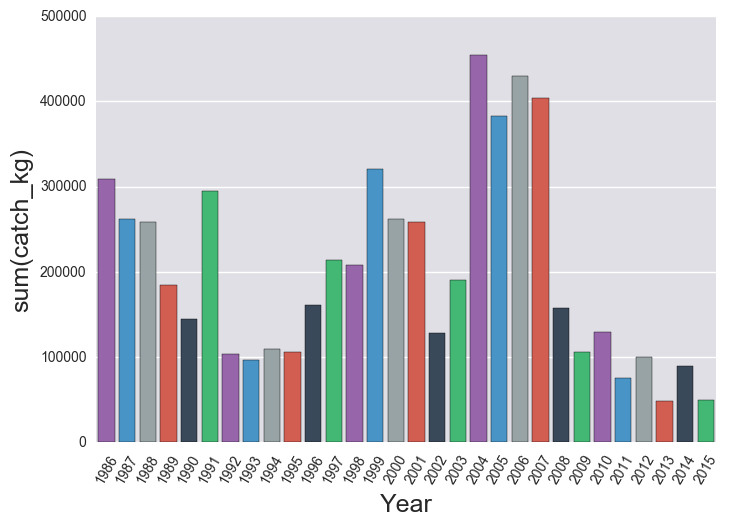

In [22]:
sns.barplot(x=data['Year'], y=data['catch_kg'], palette=sns.color_palette(flatui),ci=None, estimator=np.sum)
plt.xticks(rotation=60)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

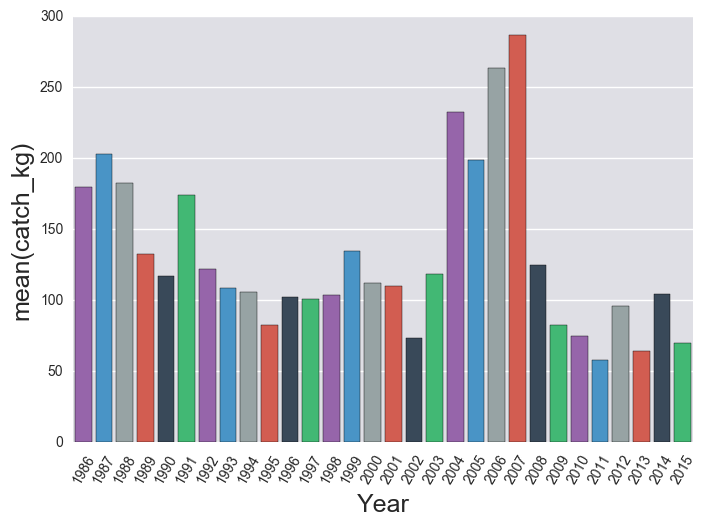

In [23]:
sns.barplot(x=data['Year'], y=data['catch_kg'], palette=sns.color_palette(flatui),ci=None, estimator=np.mean)
plt.xticks(rotation=60)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

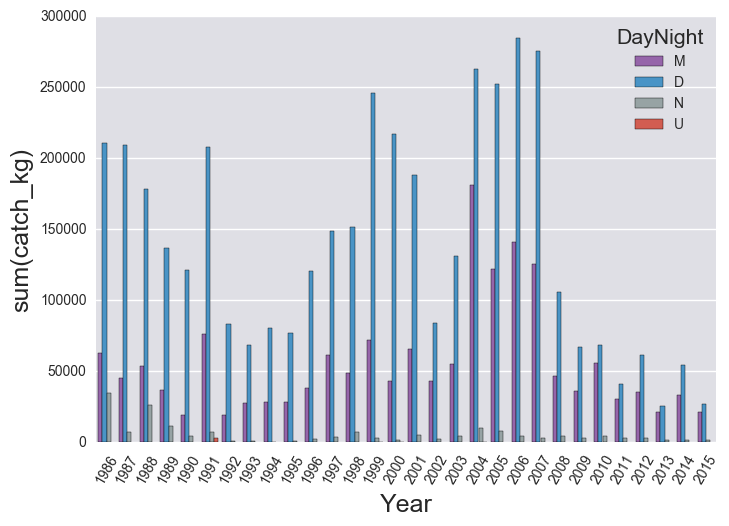

In [24]:
sns.barplot(x=data['Year'], y=data['catch_kg'], palette=sns.color_palette(flatui),ci=None, 
            hue=data['DayNight'], estimator=np.sum)
plt.xticks(rotation=60)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

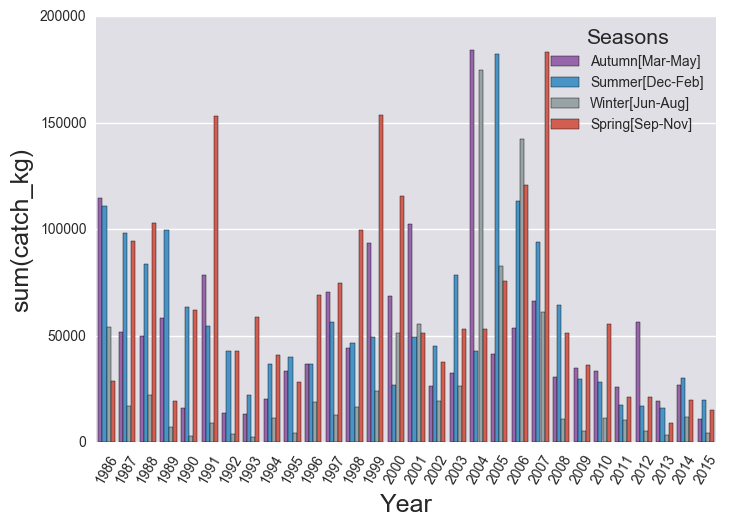

In [25]:
sns.barplot(x=data['Year'], y=data['catch_kg'], palette=sns.color_palette(flatui),ci=None, 
            hue=data['Seasons'], estimator=np.sum)
plt.xticks(rotation=60)

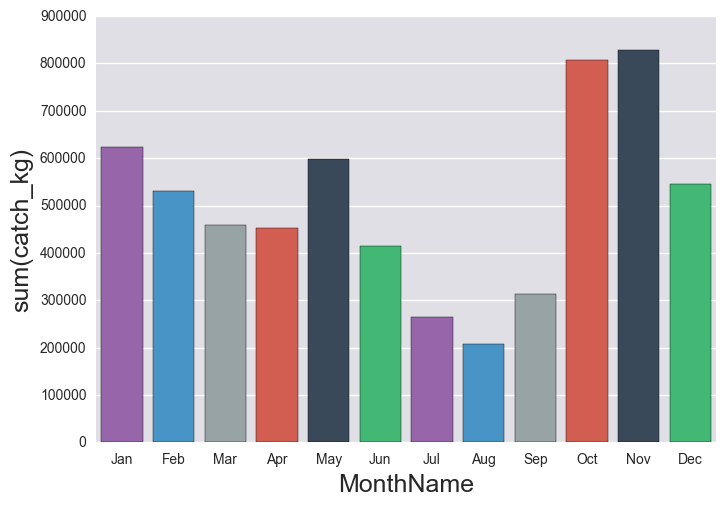

In [26]:
sns.barplot(x=data['MonthName'], y=data['catch_kg'], palette=sns.color_palette(flatui),ci=None, 
            estimator=np.sum, order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

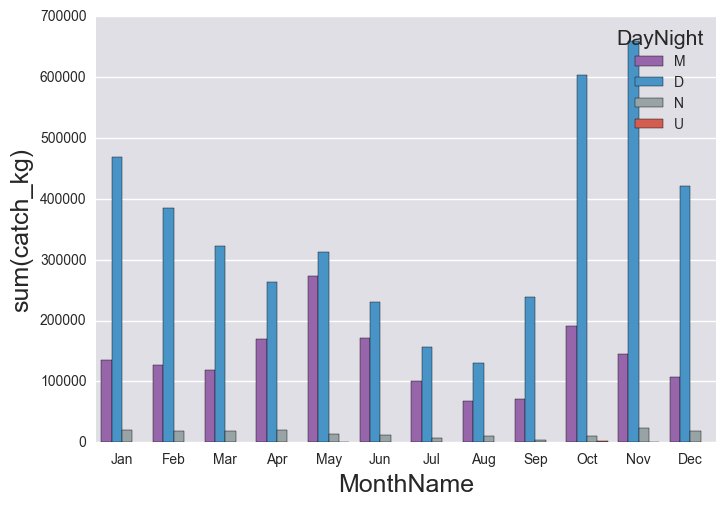

In [27]:
sns.barplot(x=data['MonthName'], y=data['catch_kg'], palette=sns.color_palette(flatui),ci=None, hue=data['DayNight'], 
            estimator=np.sum, order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

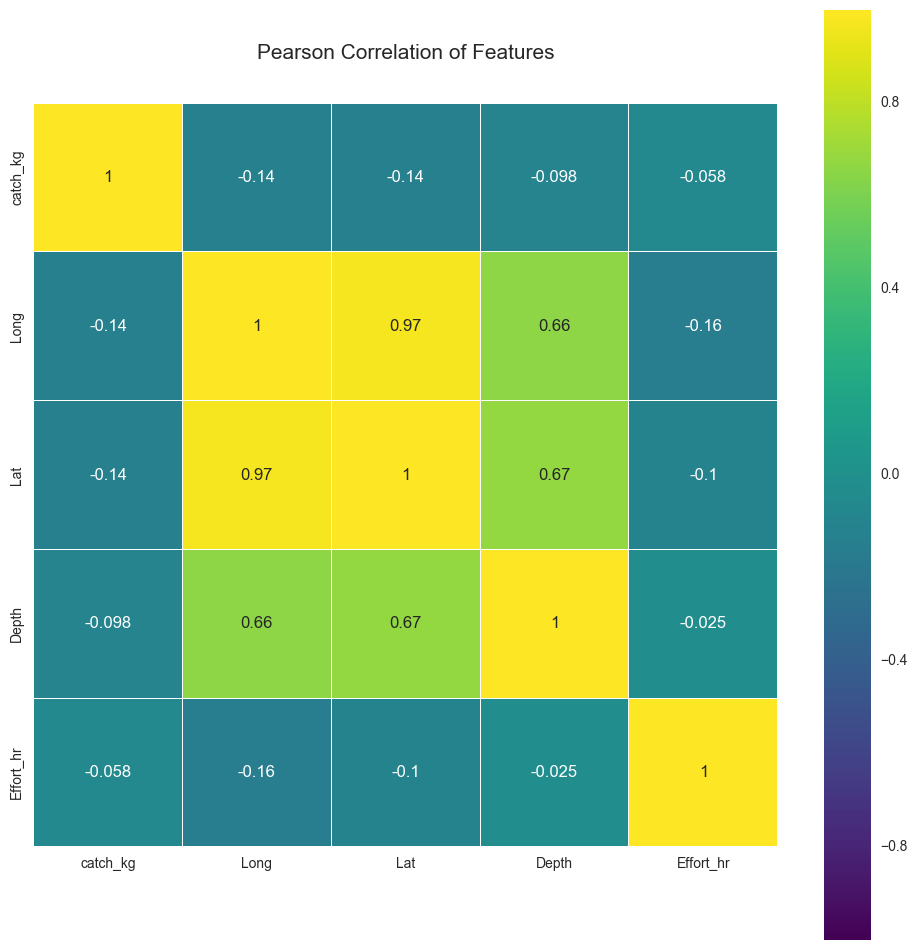

In [28]:
def plotcorrFloat(df):
    corr = df[["catch_kg","Long","Lat","Depth","Effort_hr"]].corr()
    colormap = plt.cm.viridis
    plt.figure(figsize=(12, 12))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    return sns.heatmap(corr, vmax=1, square=True, linewidths=0.1, cmap=colormap, linecolor='white', annot=True)

plotcorrFloat(data)

## Model prediction
For the model prediction, I will be using a regressor of  gradient boosted decision trees to predict the catch. In particular, I will use XGBoost. It is an algorithm that has recently been dominating applied machine learning and [**Kaggle competitions**](https://www.kaggle.com/competitions) for structured data.

[**XGBoost**](http://xgboost.readthedocs.io/en/latest/model.html) is an implementation of gradient boosted decision trees designed for speed and performance. [**Szilard Pafka's excellent benchmark**](https://github.com/szilard/benchm-ml) of a variety of machine learning libraries attest to XGBoost fast computation speed.

In [29]:
#import model libraries
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler 
import scipy.stats as st
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
#Import evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#Import module for saving scikit-learn models - Joblib is an alternative to Python's pickle package
from sklearn.externals import joblib

In [30]:
#Separate target from other features: target (y) features & input (X) features
Y = data.catch_kg
X = data.drop(['Year', 'Day', 'catch_kg', 'MonthName', 'Seasons'], axis=1)

## Applying Ordinal Encoding to Categoricals
We need to convert some features into categorical group to make processing simpler. The columns Vessel_ID represents categorical feature. However, because it is an integer, it is initially parsed as continuous number. It is also required to encode features like DayNight with a string category since XGBoost (like all of the other machine learning algorithms in Python) requires every feature vector to include only digits. 

In [31]:
CategLs = ['Month', 'DayNight', 'Vessel_ID'] # Categorical features  'Vessel_ID',
for fea in X[CategLs]: # Loop through all columns in the dataframe
    X[fea] = pd.Categorical(X[fea]).codes # Convert to categorical features

In [32]:
#Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.35, random_state=123)

#### Next step is to separate features into numeric/categorical groups to make scaling  which is needed for accurate prediction simple for numeric features. 

In [33]:
X_train_Cat = X_train[CategLs]
X_test_Cat = X_test[CategLs]

X_train_Num = X_train.drop(CategLs, axis=1)
X_test_Num = X_test.drop(CategLs, axis=1)

In [34]:
scaler = StandardScaler() # create scaler object
scaler.fit(X_train_Num) # fit with the training data ONLY
X_train_Num = scaler.transform(X_train_Num) 
X_test_Num = scaler.transform(X_test_Num) 

In [35]:
X_train_tot = pd.concat([pd.DataFrame(X_train_Num), X_train_Cat.reset_index(drop=True)], axis=1)
X_test_tot = pd.concat([pd.DataFrame(X_test_Num), X_test_Cat.reset_index(drop=True)], axis=1)

## Hyperparameter Optimization
Randomized search is used instaed of grid search for hyperparameter tuning  because of its speed.

In [36]:
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive
}

xgbreg = XGBRegressor(nthread=-1)
rsCV = RandomizedSearchCV(xgbreg, params, n_jobs=1)  
rsCV.fit(X_train_tot, Y_train)
rsCV.best_params_, rsCV.best_score_

clf = XGBRegressor(**rsCV.best_params_)
clf.fit(X_train_tot, Y_train)

print("MAE: %.4f" % mean_absolute_error(Y_test, clf.predict(X_test_tot)))

MAE: 113.3079
